# pix2pixとU-Netの比較
2つのモデルが出力する画像を比較する。

## 前準備
### 主要パッケージのインポート

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/chest_xray')
INPUT_IMAGE_DIR = 'bone_enhancement'
TRUTH_IMAGE_DIR = 'bone_suppression'
CLASS_LABELS = ('lung')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
def create_dataset_df(data_root, input_dir, truth_dir, image_ext):
    dfs = []
    root = pathlib.Path(data_root)
    image_filenames = (root / pathlib.Path(input_dir)).glob('*' + image_ext)
    df = pd.DataFrame(image_filenames, columns=['input_path'])
    df['truth_path'] = df['input_path'].map(
        lambda p: root / pathlib.Path(truth_dir) / p.name)
    return df


df_dataset = create_dataset_df(DATA_ROOT, INPUT_IMAGE_DIR, TRUTH_IMAGE_DIR,
                               IMAGE_EXT)
display(df_dataset.head())

,input_path,truth_path
0,Data\Images\chest_xray\bone_enhancement\000.png,Data\Images\chest_xray\bone_suppression\000.png
1,Data\Images\chest_xray\bone_enhancement\001.png,Data\Images\chest_xray\bone_suppression\001.png
2,Data\Images\chest_xray\bone_enhancement\002.png,Data\Images\chest_xray\bone_suppression\002.png
3,Data\Images\chest_xray\bone_enhancement\003.png,Data\Images\chest_xray\bone_suppression\003.png
4,Data\Images\chest_xray\bone_enhancement\004.png,Data\Images\chest_xray\bone_suppression\004.png


### ホールドアウトされたデータの取り出し

In [4]:
from sklearn.model_selection import KFold
N_SPLITS = 5
SEED = 0
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
train_index, test_index = next(kfold.split(df_dataset['input_path']))

df_train = df_dataset.iloc[train_index]
df_test = df_dataset.iloc[test_index]

In [5]:
import torch
import functools
import tut_utils
INPUT_SHAPE = [1, 256, 256]
IMG_SHAPE = INPUT_SHAPE
N_COMPARE = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def load_img(filepath):
    img = Image.open(filepath)
    img = img.resize(IMG_SHAPE[1:])
    return np.atleast_3d(img)


load_img2img_dataset = functools.partial(tut_utils.load_img2img_dataset,
                                         input_column='input_path',
                                         target_column='truth_path')
test_data, test_labels = load_img2img_dataset(df_test[:N_COMPARE], load_img)
test_data = torch.from_numpy(
    (test_data.transpose(0, 3, 1, 2) / 255).astype(np.float32))
test_data = test_data.to(device)
device

device(type='cuda', index=0)

## 画像変換
### U-Net

In [6]:
from tut_models import UNet
UNET_DEPTH = 6
IN_CHS = 1
OUT_CHS = 1
INI_CHS = 16

net = UNet(IN_CHS, OUT_CHS, UNET_DEPTH)
net.load_state_dict(torch.load('unet_generator.ckpt'))
net.to(device)
net.eval()
with torch.no_grad():
    unet_prediction = net(test_data).cpu().numpy().squeeze()

### pix2pix

In [7]:
net = UNet(IN_CHS, OUT_CHS, UNET_DEPTH)
net.load_state_dict(torch.load('pix2pix_generator.ckpt'))
net.to(device)
net.eval()
with torch.no_grad():
    pix2pix_prediction = net(test_data).cpu().numpy().squeeze()

## 比較

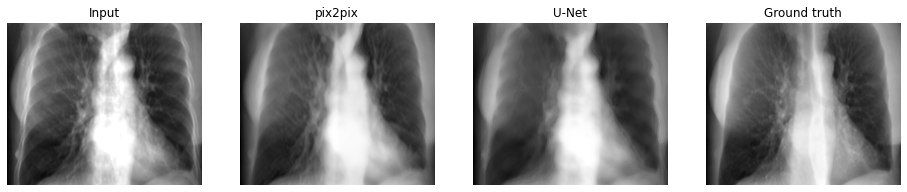

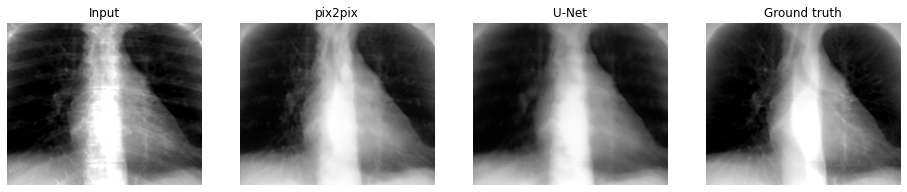

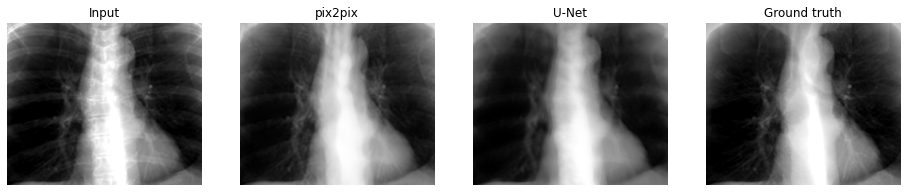

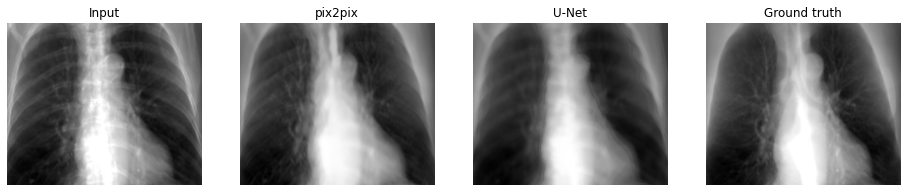

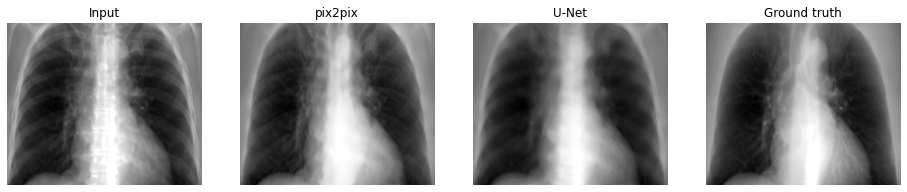

In [8]:
def crop_and_show(image):
    margin = 32
    plt.imshow(image[margin:-margin * 2, margin:-margin], cmap='gray')


for data, target, pix2pix, unet in zip(test_data.cpu().numpy(), test_labels,
                                       pix2pix_prediction, unet_prediction):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    crop_and_show(data.squeeze())
    plt.title('Input')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    crop_and_show(pix2pix.squeeze())
    plt.title('pix2pix')
    plt.axis('off')
    plt.subplot(1, 4, 3)
    crop_and_show(unet.squeeze())
    plt.title('U-Net')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    crop_and_show(target.squeeze())
    plt.title('Ground truth')
    plt.axis('off')
    plt.show()